In [1]:
import os

import pyrootutils

PROJECT_ROOT_DIR = pyrootutils.setup_root(os.path.abspath(''), dotenv=True, pythonpath=True)
os.chdir(PROJECT_ROOT_DIR)

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Polygon
from sklearn.ensemble import (AdaBoostRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

from src.utils_data_centric import _get_all_data_set_characteristics
from src.utils_performance import _all_algorithms_all_datasets_performance
from src.utils_visualization import NotebookFigureSaver

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

CHAPTER_ID = "e_performance_estimation"
fig_saver = NotebookFigureSaver(CHAPTER_ID)

In [2]:
def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test):
    """
    This function fits a machine learning model on our algorithm performance estimation and evaluates
    on both validation and test datasets. It computes Mean Absolute Error (MAE) and Mean Squared Error
    (MSE) for model predictions against actual values. Additionally, it compares the model's performance
    to a naive baseline (predicting the mean of the training labels for all instances) to quantify
    the relative improvement of the model over this baseline.

    Parameters:
    - model: The machine learning model to be evaluated. Must support fit() and predict() methods.
    - X_train: Training feature dataset.
    - X_val: Validation feature dataset.
    - X_test: Test feature dataset.
    - y_train: Training target dataset.
    - y_val: Validation target dataset.
    - y_test: Test target dataset.

    Returns:
    - results_dict (dict): A dictionary containing the raw predictions and evaluation metrics (MAE,
      MSE, and relative improvements over the naive baseline) for both validation and test sets.
    """
    
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)

    # Predict on the test set
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Naive baseline performance for validation and test
    naive_baseline_val = np.repeat(y_train.mean(), len(y_val))
    naive_baseline_test = np.repeat(y_train.mean(), len(y_test))

    mae_naive_val = mean_absolute_error(naive_baseline_val, y_val)
    mse_naive_val = mean_squared_error(naive_baseline_val, y_val)
    mae_naive_test = mean_absolute_error(naive_baseline_test, y_test)
    mse_naive_test = mean_squared_error(naive_baseline_test, y_test)

    # Calculate relative improvement for validation and test for both MAE and MSE
    relative_improvement_mae_val = (mae_val - mae_naive_val) / mae_naive_val
    relative_improvement_mse_val = (mse_val - mse_naive_val) / mse_naive_val
    relative_improvement_mae_test = (mae_test - mae_naive_test) / mae_naive_test
    relative_improvement_mse_test = (mse_test - mse_naive_test) / mse_naive_test

    # Extending results_dict with MSE improvements
    results_dict = {
        "Validation": {
            "raw_predictions": {
                "GT Performance": y_val,
                "Estimated Performance": y_pred_val,
                "Naive Baseline": naive_baseline_val,
            },
            "metrics":{
                "Naive MAE": mae_naive_val,
                "Naive MSE": mse_naive_val,
                "Model MAE": mae_val,
                "Model MSE": mse_val,
                "Improvement MAE": relative_improvement_mae_val,
                "Improvement MSE": relative_improvement_mse_val,
            },
        },
        "Test": {
            "raw_predictions": {
                "GT Performance": y_test,
                "Estimated Performance": y_pred_test,
                "Naive Baseline": naive_baseline_test,
            },
            "metrics":{
                "Naive MAE": mae_naive_test,
                "Naive MSE": mse_naive_test,
                "Model MAE": mae_test,
                "Model MSE": mse_test,
                "Improvement MAE": relative_improvement_mae_test,
                "Improvement MSE": relative_improvement_mse_test,
            }
        }
    }
    
    return results_dict


def _get_best_model_for_each_task(results_dict, metric_to_use_for_selection):
    """
    This function iterates over a nested dictionary of results from different models applied to various tasks.
    It selects the best model for each task based on the specified metric's value on the validation dataset.

    Parameters:
    - results_dict (dict): A nested dictionary containing performance metrics for models applied to different tasks.
      The expected structure is: {task: {performance_metric: {model: {"Validation": {"metrics": {metric: value}},
      "Test": {"metrics": {metric: value}}}}}}.
    - metric_to_use_for_selection (str): The metric name to use for model selection (e.g., "Improvement MAE").

    Returns:
    - best_model_dict (dict): A dictionary mapping each task to its best model and performance metrics. The structure
      is: {task: {performance_metric: (best_model, {"validation": validation_metric_value, "test": test_metric_value})}}.

    """
    best_model_dict = {}
    for ts_algorithm_to_predict in results_dict.keys():
        best_model_dict[ts_algorithm_to_predict] = {}
        
        for performance_to_predict in results_dict[ts_algorithm_to_predict].keys():
            best_model = None
            best_model_improvement = np.inf
            for performance_estimator_model in results_dict[ts_algorithm_to_predict][performance_to_predict].keys():
                improvement = results_dict[ts_algorithm_to_predict][performance_to_predict][performance_estimator_model]["Validation"]["metrics"][metric_to_use_for_selection]
                if improvement < best_model_improvement:
                    best_model_improvement = improvement
                    best_model = performance_estimator_model
            print(f"Best model for {ts_algorithm_to_predict} and {performance_to_predict} is {best_model} with improvement {best_model_improvement}")
            test_performance = results_dict[ts_algorithm_to_predict][performance_to_predict][best_model]["Test"]["metrics"][metric_to_use_for_selection]
            best_model_dict[ts_algorithm_to_predict][performance_to_predict] = (best_model, {"validation":best_model_improvement.round(2),
                                                                                             "test":test_performance.round(2)})
    return best_model_dict

def _get_visual_frame(results_dict, metric_to_use_for_selection):
    """
    This function processes a results dictionary to identify the best models for each task and metric,
    using a specified selection metric. It constructs a DataFrame suitable for visualization purposes,
    containing information about the best models, their validation and test performance, and prepares
    annotations for these performances.

    Parameters:
    - results_dict (dict): A dictionary containing performance metrics for various models across different tasks.
    - metric_to_use_for_selection (str): The metric used to select the best model for each task.

    Returns:
    - data_to_visualize_df (pd.DataFrame): A DataFrame with the best models for each task and performance metric.
    - text_to_annotate (dict): Annotations indicating the validation and test performance of the best models.
    - overall_data_frame (pd.DataFrame): A consolidated DataFrame with detailed information about the best models,
      including their performance on validation and test sets for all tasks and metrics.
    """
    
    best_model_dict = _get_best_model_for_each_task(results_dict, metric_to_use_for_selection)
    
    # first we need to build a dataframe with the data we want to visualize
    data_to_visualize = {}
    text_to_annotate = {}
    overall_data_frame = pd.DataFrame()
    # iterate over the time series algorithm which performance we want to predict
    for ts_algorithm_to_predict in best_model_dict.keys():
        
        # iterate over the characteristics of the performance we want to predict, namely the mean and the std
        for performance_to_predict in best_model_dict[ts_algorithm_to_predict].keys():
            best_model, performance = best_model_dict[ts_algorithm_to_predict][performance_to_predict]
            if ts_algorithm_to_predict not in data_to_visualize:
                data_to_visualize[ts_algorithm_to_predict] = {}
                text_to_annotate[ts_algorithm_to_predict] = {}
            data_to_visualize[ts_algorithm_to_predict][performance_to_predict] = best_model
            text_to_annotate[ts_algorithm_to_predict][performance_to_predict] = str(performance["validation"]) + " / " +str(performance["test"])
            overall_data_frame = pd.concat([overall_data_frame, pd.DataFrame({"Algorithm":ts_algorithm_to_predict,"predict":performance_to_predict, "Validation":performance["validation"], "Test":performance["test"]},index=[0])],ignore_index=True)
            
    data_to_visualize_df = pd.DataFrame(data_to_visualize).T
    
    return data_to_visualize_df, text_to_annotate, overall_data_frame

In [3]:
# get the characteristic statistics on all data sets
normalized_data_set_characteristics = _get_all_data_set_characteristics(
    number_data_sets=None, normalize_each_characteristic=True
)
X = pd.DataFrame(normalized_data_set_characteristics)

# get the mean performance of all algorithms on all data sets
algorithm_data_set_performance = _all_algorithms_all_datasets_performance(
    performance_of_interest="$\\hat{\\mu}$"
)
# get the std performance "$\hat{\sigma}$" of all algorithms on all data sets
algorithm_data_set_performance_std = _all_algorithms_all_datasets_performance(
    performance_of_interest="$\hat{\sigma}$"
)

Y_mean = pd.DataFrame(algorithm_data_set_performance).T
Y_std = pd.DataFrame(algorithm_data_set_performance_std).T

# inner join x and y on index
matched_data_sets_mean = X.join(Y_mean, how="inner")
matched_data_sets_std = X.join(Y_std, how="inner")

In [4]:
algorithm_data_set_performance

,Adiac,ArrowHead,Beef,BeetleFly,BirdChicken,Car,CBF,ChlorineConcentration,CinCECGTorso,Coffee,...,GesturePebbleZ1Eq,GesturePebbleZ2Eq,KeplerLightCurves,MelbournePedestrianNmv,PhoneHeartbeatSound,PickupGestureWiimoteZEq,PLAIDEq,ShakeGestureWiimoteZEq,SharePriceIncrease,Tools
ResNet_ACC,0.815431,0.858667,0.676667,0.853333,0.945000,0.908333,0.988222,0.841007,0.767874,0.996429,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1NN-DTW_ACC,0.603410,0.722095,0.504444,0.775000,0.840000,0.675000,0.993481,0.644054,0.668502,0.985714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EE_ACC,0.657374,0.860381,0.515556,0.756667,0.836667,0.785556,0.982593,0.652778,0.934034,0.983333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WEASEL-D_ACC,0.817818,0.885143,0.776667,0.946667,0.933333,0.907778,0.980667,0.768030,0.925821,0.997619,...,0.961047,0.969198,0.923893,0.920885,0.640842,0.820667,0.898510,0.927333,0.686163,0.882587
RSF_ACC,0.669906,0.777714,0.466667,0.875000,0.833333,0.758333,0.970185,0.605920,0.771643,0.941667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNN_ACC,0.387383,0.759810,0.667778,0.791667,0.705000,0.740000,0.934185,0.594080,0.660169,0.994048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Catch22_ACC,0.697187,0.760000,0.484444,0.851667,0.888333,0.738889,0.950778,0.598741,0.800217,0.984524,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TSF_ACC,0.715686,0.784190,0.677778,0.823333,0.821667,0.746111,0.963519,0.732144,0.971570,0.989286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RDST_ACC,0.739898,0.878286,0.742222,0.926667,0.913333,0.937778,0.990963,0.760035,0.982126,0.995238,...,0.971318,0.974895,0.928404,0.959465,0.668681,0.822000,0.917753,0.937333,0.660248,0.862687
TSFresh_ACC,0.789770,0.613143,0.734444,0.500000,0.608333,0.786667,0.984370,0.587049,0.953671,0.969048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Define the regression models to test
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge": Ridge(),
    "DecisionTree": DecisionTreeRegressor(min_samples_leaf=5, random_state=42),
    "SVR": SVR(),
    "GradientBoosting": GradientBoostingRegressor(),
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoost": AdaBoostRegressor(),
}


test_size = 0.2
validation_size = 0.2
train_size = 1 - test_size - validation_size
random_seed = 0

results_dict = {}

for ts_algorithm_to_predict in Y_mean.columns:
    results_dict[ts_algorithm_to_predict] = {}

    for performance_to_predict in ["mean", "std"]:
        matched_data_sets = matched_data_sets_mean if performance_to_predict == "mean" else matched_data_sets_std

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            matched_data_sets[X.columns],
            matched_data_sets[ts_algorithm_to_predict],
            test_size=test_size,
            random_state=random_seed,
        )
        
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=validation_size/(train_size+validation_size), random_state=random_seed)


        results_dict[ts_algorithm_to_predict][performance_to_predict] = {}
        for performance_estimator_model, model in models.items():
            results_dict[ts_algorithm_to_predict][performance_to_predict][performance_estimator_model] = {}
            single_result_dict = evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test)
            results_dict[ts_algorithm_to_predict][performance_to_predict][performance_estimator_model] = single_result_dict


metric_to_use_for_selection = "Improvement MSE"
data_to_visualize_df_mse, text_to_annotate_mse, overall_data_frame_mse = _get_visual_frame(results_dict, metric_to_use_for_selection)

metric_to_use_for_selection = "Improvement MAE"
data_to_visualize_df_mae, text_to_annotate_mae, overall_data_frame_mae = _get_visual_frame(results_dict, metric_to_use_for_selection)

algorithm_names = [
    algorithm_name.replace("_ACC", "") if algorithm_name.endswith("_ACC") else algorithm_name 
    for algorithm_name in data_to_visualize_df_mse.index
]

Best model for ResNet_ACC and mean is RandomForest with improvement -0.027515650204542774
Best model for ResNet_ACC and std is RandomForest with improvement 0.003956797773149662
Best model for 1NN-DTW_ACC and mean is Ridge with improvement -0.4176344237506208
Best model for 1NN-DTW_ACC and std is RandomForest with improvement -0.6333014925689837
Best model for EE_ACC and mean is Ridge with improvement -0.3881890849007242
Best model for EE_ACC and std is DecisionTree with improvement -0.5088971481384912
Best model for WEASEL-D_ACC and mean is AdaBoost with improvement -0.12691178107892706
Best model for WEASEL-D_ACC and std is RandomForest with improvement -0.33787467548461453
Best model for RSF_ACC and mean is Ridge with improvement -0.17610100827557537
Best model for RSF_ACC and std is RandomForest with improvement -0.5883504080800444
Best model for CNN_ACC and mean is Ridge with improvement -0.42195858944377423
Best model for CNN_ACC and std is AdaBoost with improvement -0.7045615008

In [6]:
overall_data_frame_mae_sorted = overall_data_frame_mae.sort_values(by=[ "Algorithm"])

Saving figure change_performance_only_mae


/var/folders/ct/qpfxjbdn1xx4fvb2v099sg_00000gn/T/ipykernel_5411/1037225246.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(algorithm_names, rotation=90, ha="center")


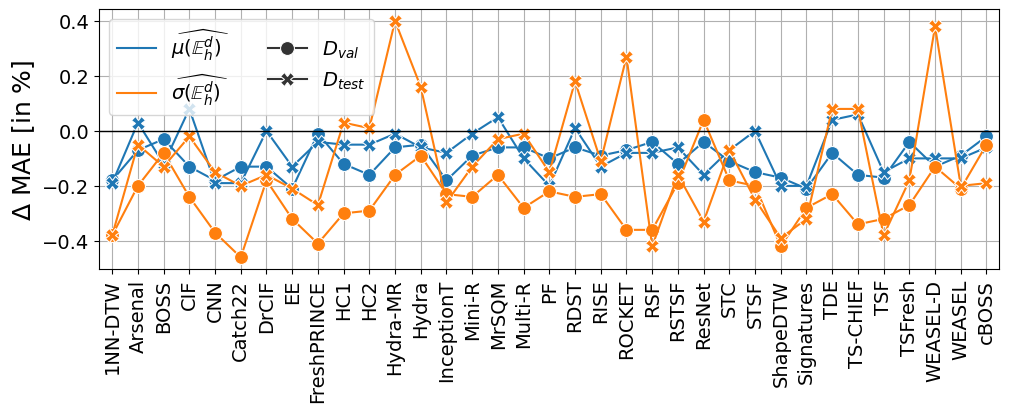

In [7]:
overall_data_frame_mae_sorted = overall_data_frame_mae.sort_values(by=[ "Algorithm"])
df_melted_mae = overall_data_frame_mae_sorted.melt(id_vars=["Algorithm", "predict"], var_name="Subset data", value_name="Performance")

# Prepare algorithm names for x-tick labels, stripping "_ACC"
algorithm_names = [
    algorithm_name.replace("_ACC", "") if "_ACC" in algorithm_name else algorithm_name 
    for algorithm_name in overall_data_frame_mae_sorted['Algorithm'].unique()
]

# Replace values for readability
replace_dict = {"mean": "$\widehat{\mu(\mathbb{E}_{h}^{d})}$", "std": "$\widehat{\sigma(\mathbb{E}_{h}^{d})}$"}
df_melted_mae["predict"] = df_melted_mae["predict"].map(replace_dict)

subset_replace_dict = {"Validation": "$D_{val}$", "Test": "$D_{test}$"}
df_melted_mae["Subset data"] = df_melted_mae["Subset data"].map(subset_replace_dict)

# Create the plots
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)

# Line plot for MAE
sns.lineplot(data=df_melted_mae, x="Algorithm", y="Performance", hue="predict", style="Subset data", markers=True, markersize=10, dashes=False, ax=ax)
ax.set_ylabel("$\Delta$ MAE [in $\%$]", fontsize=18)
ax.set_xlim(-0.5, len(df_melted_mae['Algorithm'].unique()) - 0.5)
ax.set_xlabel("", fontsize=18)
ax.tick_params(axis="x", labelsize=14) 
ax.tick_params(axis="y", labelsize=14) 
# Custom legend for MAE
handles, labels = ax.get_legend_handles_labels()
new_labels = [label for label in labels if label in replace_dict.values() or label in subset_replace_dict.values()]
new_handles = [handles[labels.index(label)] for label in new_labels]
ax.legend(new_handles, new_labels, loc='upper left', ncol=2, fontsize=14)
ax.hlines(0, -0.5, len(df_melted_mae['Algorithm'].unique()) - 0.5, color="black", linestyle="-", linewidth=1)
ax.grid(True)

ax.set_xticklabels(algorithm_names, rotation=90, ha="center")

plt.subplots_adjust(hspace=.05, wspace=0.05, left=0.1, right=1., bottom=0.35, top=1.)
fig_saver.save_fig(f"change_performance_only_mae")
plt.show()


In [8]:
def _visualise_single_algorithm(applied_algorithm = "1NN-DTW_ACC", model_name = "RandomForest",to_predict = 'mean', save_figure = False):

    fig_size = (10, 8)
    fig, ax = plt.subplots(2, 1, figsize=fig_size, sharex=False, sharey=False)
    

    for y_ax, data_sub_set in enumerate(['Validation', 'Test']):

        gt_performance = results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["GT Performance"].values
        estimated_performance = results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions'][
            "Estimated Performance"
        ]
        naive_baseline = results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["Naive Baseline"][0]

        ax[y_ax].scatter(
            gt_performance,
            estimated_performance,
            label=r'Estimations $\widehat{\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Estimations $\widehat{\sigma(\mathbb{E}_{h}^{d})}$',
            marker='o',
            s=100,
            alpha=0.7,
        )
        ax[y_ax].plot(
            [
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["GT Performance"].values.min()*0.95,
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["GT Performance"].values.max(),
            ],
            [
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["Naive Baseline"].max(),
                results_dict[applied_algorithm][to_predict][model_name][data_sub_set]['raw_predictions']["Naive Baseline"].min(),
            ],
            color='tab:orange', linewidth=3, linestyle='--', 
            label= r'Naive Baseline $\ddot{\mu}_{h}^d$' if to_predict == 'mean' else r'Naive Baseline $\ddot{\sigma}_{h}^d$'
            
        )
        # Plot the perfect prediction line
        ax[y_ax].plot([0., 1], [0., 1], color='black', linewidth=3, linestyle='--', label=r'Perfect Prediction ${\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Perfect Prediction ${\sigma(\mathbb{E}_{h}^{d})}$')
        
        ax[y_ax].add_patch(Polygon([(naive_baseline,naive_baseline), (0,naive_baseline), (0,-naive_baseline)], facecolor='none', edgecolor='green', hatch='//', label='Better than Naive'))
        ax[y_ax].add_patch(Polygon([(naive_baseline,naive_baseline), (1,naive_baseline), (1,2-naive_baseline)], facecolor='none', edgecolor='green', hatch='//', label=''))

                
        
        
        ax[y_ax].set_xlim(min(gt_performance.min(), estimated_performance.min())*0.95, max(gt_performance.max(), estimated_performance.max()))
        ax[y_ax].set_ylim(min(gt_performance.min(), estimated_performance.min())*0.95, max(gt_performance.max(), estimated_performance.max()))

        if y_ax == 0:
            ax[y_ax].set_ylabel(r'Estimations $\widehat{\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Estimations $\widehat{\sigma(\mathbb{E}_{h}^{d})}$', fontsize=18)
            ax[y_ax].legend(loc='lower left' if to_predict == 'mean' else "upper left", ncol=2, fontsize=14)
            ax[y_ax].set_title(r"$d \in D_{val}$", fontsize=18)
            
        else:
            ax[y_ax].set_xlabel(r'Ground truth ${\mu(\mathbb{E}_{h}^{d})}$' if to_predict == 'mean' else r'Ground truth ${\sigma(\mathbb{E}_{h}^{d})}$' , fontsize=18)
            ax[y_ax].set_title(r"$d \in D_{test}$", fontsize=18)
        
        ax[y_ax].tick_params(axis="x",labelsize=18)
        ax[y_ax].tick_params(axis="y", labelsize=18)
        
        
    plt.subplots_adjust(hspace=.25, wspace=0., left=0.11, right=0.95, bottom=0.1, top=.95)
    
    if save_figure:
        fig_saver.save_fig(f"performance_comparison_{applied_algorithm}_{model_name}_{to_predict}")
    plt.show()
    

Saving figure performance_comparison_1NN-DTW_ACC_Ridge_mean


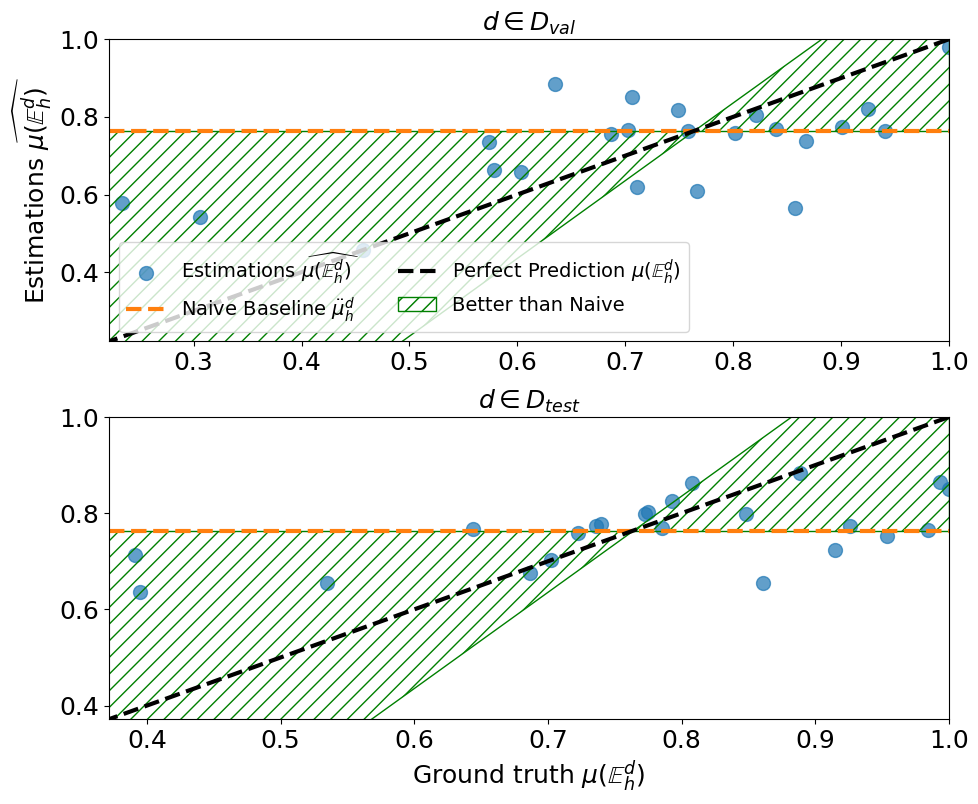

In [9]:
_visualise_single_algorithm(applied_algorithm = "1NN-DTW_ACC", model_name = "Ridge",to_predict = 'mean', save_figure = True)

Saving figure performance_comparison_1NN-DTW_ACC_RandomForest_std


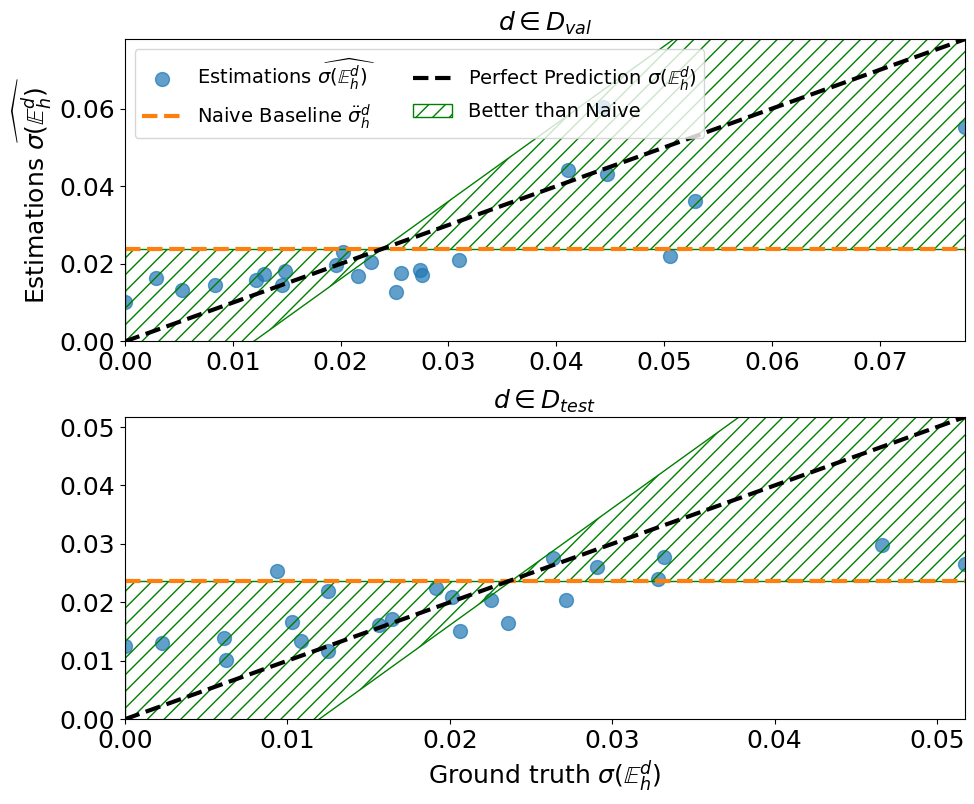

In [10]:
_visualise_single_algorithm(applied_algorithm = "1NN-DTW_ACC", model_name = "RandomForest",to_predict = 'std', save_figure = True)

In [11]:
# Initialize a list to store the multi-index and columns data
records = []

# Iterate over the nested dictionary structure
for experiment, metrics_dict in results_dict.items():
    for metric, models_dict in metrics_dict.items():
        for model, datasets_dict in models_dict.items():
            for dataset, metrics_data in datasets_dict.items():
                for evaluation_metric, value in metrics_data['metrics'].items():
                    records.append({
                        'Algorithm': experiment,
                        'estimate': metric,
                        'Model': model,
                        'Dataset': dataset,
                        'Metric': evaluation_metric,
                        'Value': value
                    })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(records)

# Pivot the DataFrame to get a multi-level column structure
df_pivoted = df.pivot_table(index=['Algorithm', 'estimate'],
                            columns=['Model', 'Dataset', 'Metric'],
                            values='Value').reset_index()

# Function to combine metrics into a single string for each 'MAE' and 'MSE'
def combine_metrics(row, metrics):
    combined_metrics = {}
    for metric in metrics:
        naive = row[f"Naive {metric}"]
        model = row[f"Model {metric}"]
        improvement = (model - naive) / naive * 100  
        combined_metrics[metric] = f"{improvement:.2f}"
    return pd.Series(combined_metrics)

# Iterate over unique 'Model' and 'Dataset' pairs to apply the combine_metrics function
for (model, dataset), group_df in df.groupby(['Model', 'Dataset']):
    metrics = ['MAE', 'MSE']
    combined = df_pivoted.apply(lambda row: combine_metrics(row[(model, dataset)], metrics), axis=1)
    for metric in metrics:
        df_pivoted[(model, dataset, metric)] = combined[metric]

df_pivoted.set_index(['Algorithm', 'estimate'], inplace=True)

idx = pd.IndexSlice
filtered_df_MAE = df_pivoted.loc[:, idx[:, :, ['MAE']]]
filtered_df_MSE = df_pivoted.loc[:, idx[:, :, ['MSE']]]

In [12]:
filtered_df_MAE = filtered_df_MAE.reset_index(drop=False)
filtered_df_MAE[(       'Algorithm',           '',    '')] = filtered_df_MAE[(       'Algorithm',           '',    '')].apply(
    lambda x: x.replace("_ACC", "") if x.endswith("_ACC") else x
)
print(filtered_df_MAE.to_latex(index=True))

\begin{tabular}{lllllllllllllllll}
\toprule
Model & Algorithm & estimate & \multicolumn{2}{r}{AdaBoost} & \multicolumn{2}{r}{DecisionTree} & \multicolumn{2}{r}{GradientBoosting} & \multicolumn{2}{r}{KNeighbors} & \multicolumn{2}{r}{RandomForest} & \multicolumn{2}{r}{Ridge} & \multicolumn{2}{r}{SVR} \\
Dataset &  &  & Test & Validation & Test & Validation & Test & Validation & Test & Validation & Test & Validation & Test & Validation & Test & Validation \\
Metric &  &  & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE & MAE \\
\midrule
0 & 1NN-DTW & mean & 6.02 & -13.13 & 32.00 & 19.50 & 2.19 & -6.98 & -9.41 & 2.16 & -0.62 & -13.57 & -18.61 & -18.13 & -7.36 & -5.95 \\
1 & 1NN-DTW & std & -25.23 & -27.95 & -23.11 & -30.61 & -32.30 & -33.27 & -15.90 & -13.70 & -37.66 & -37.53 & -8.37 & -6.32 & 119.22 & 55.43 \\
2 & Arsenal & mean & 2.60 & -6.62 & -22.91 & 16.38 & -13.38 & 27.71 & -7.52 & -0.09 & -0.87 & -4.58 & -19.51 & 5.71 & -6.42 & 7.58 \\
3 & Arsenal & std 

In [13]:
# Initialize a list to hold extracted data for DataFrame
data = []

# Determine the best model for each task based on validation set performance
best_model_dict = _get_best_model_for_each_task(results_dict, metric_to_use_for_selection)

# Iterate over the results to populate the data list
for algorithm, metrics in results_dict.items():
    for metric_type in metrics:  # 'mean' or 'std'
        best_model, _ = best_model_dict[algorithm][metric_type]
        metrics_data = results_dict[algorithm][metric_type][best_model]['Test']['metrics']
        
        # Create a record for each metric
        record = {
            'Algorithm': algorithm,
            'Metric Type': metric_type,
            'Model': best_model,
        }|metrics_data
        
        data.append(record)

# Convert the list of data to a DataFrame
df = pd.DataFrame(data)

# Pivot the DataFrame to structure 'Metric Type' as part of the column multi-level
df_pivoted = df.pivot_table(index=['Algorithm'],
                            columns=['Metric Type'],
                            aggfunc=lambda x: x)

# After pivoting, 'Metric Type' will become the top level of the columns, organizing 'mean' and 'std' accordingly
# The aggfunc=lambda x: x is a placeholder to simply return the original values
df_pivoted.sort_index(axis=1, level=1, inplace=True)

table_paper = df_pivoted.T.sort_values(by=("Metric Type")).T[[
            (          'Model', 'mean'),
            (      'Naive MAE', 'mean'),
            (      'Model MAE', 'mean'),
            ('Improvement MAE', 'mean'),
            (      'Naive MSE', 'mean'),
            (      'Model MSE', 'mean'),
            ('Improvement MSE', 'mean'),
            (          'Model',  'std'),
            (      'Naive MAE',  'std'),
            (      'Model MAE',  'std'),
            ('Improvement MAE',  'std'),
            (      'Naive MSE',  'std'),
            (      'Model MSE',  'std'),
            ('Improvement MSE',  'std'),
            ]]

Best model for ResNet_ACC and mean is AdaBoost with improvement -0.04360904878787354
Best model for ResNet_ACC and std is KNeighbors with improvement 0.04280934132222486
Best model for 1NN-DTW_ACC and mean is Ridge with improvement -0.18134421644564452
Best model for 1NN-DTW_ACC and std is RandomForest with improvement -0.3752777203588018
Best model for EE_ACC and mean is Ridge with improvement -0.21443491490559893
Best model for EE_ACC and std is DecisionTree with improvement -0.31847680668009265
Best model for WEASEL-D_ACC and mean is AdaBoost with improvement -0.12818200050403056
Best model for WEASEL-D_ACC and std is DecisionTree with improvement -0.1344978290428769
Best model for RSF_ACC and mean is KNeighbors with improvement -0.035547479347857486
Best model for RSF_ACC and std is RandomForest with improvement -0.3603864700364492
Best model for CNN_ACC and mean is Ridge with improvement -0.18026993812017622
Best model for CNN_ACC and std is AdaBoost with improvement -0.3675950114

In [14]:
# Remove the "_ACC" suffix from the algorithm names
table_paper.index = table_paper.index.str.replace("_ACC", "")

# map the model names to abbreviations of two letters
model_name_mapping = {
    'Ridge': 'Ri',
    'RandomForest': 'RF',
    'DecisionTree': 'DT',
    'GradientBoosting': 'GB',
    'AdaBoost': 'AB',
    "KNeighbors": 'KN',
}
table_paper[[
            (          'Model', 'mean'),
            (          'Model',  'std'),
            ]] = table_paper[[
            (          'Model', 'mean'),
            (          'Model',  'std'),
            ]].applymap(lambda x: model_name_mapping[x])
            
# calculate the means and add it to the table
table_paper= table_paper.convert_dtypes()
table_paper = pd.concat([table_paper, table_paper.mean(numeric_only=True).to_frame().T])
table_paper = table_paper.round(4)

# improve the readability of the table by multiplying the improvement by 100
for column in table_paper.columns:
    if "Improvement" in column[0]:
        table_paper[column] = table_paper[column]*100
        table_paper[column] = table_paper[column].map('{:,.2f}'.format)


In [15]:
table_paper

,Model,Naive MAE,Model MAE,Improvement MAE,Naive MSE,Model MSE,Improvement MSE,Model,Naive MAE,Model MAE,Improvement MAE,Naive MSE,Model MSE,Improvement MSE
Metric Type,mean,mean,mean,mean,mean,mean,mean,std,std,std,std,std,std,std
1NN-DTW,Ri,0.1277,0.1039,-18.61,0.0275,0.0189,-31.45,RF,0.011,0.0068,-37.66,0.0002,0.0001,-53.75
Arsenal,AB,0.1046,0.1073,2.60,0.0191,0.0234,23.03,RF,0.0094,0.0089,-5.24,0.0001,0.0001,-4.89
BOSS,Ri,0.1242,0.1099,-11.55,0.0235,0.0213,-9.46,Ri,0.0134,0.0117,-12.58,0.0003,0.0002,-11.26
CIF,RF,0.1072,0.1159,8.07,0.0203,0.0229,12.90,DT,0.0125,0.0122,-1.71,0.0002,0.0002,14.13
CNN,Ri,0.1786,0.144,-19.37,0.044,0.0307,-30.19,AB,0.0184,0.0156,-15.16,0.0005,0.0004,-22.77
Catch22,Ri,0.1205,0.098,-18.67,0.0228,0.0164,-28.15,DT,0.0122,0.0098,-19.92,0.0002,0.0002,-18.35
DrCIF,RF,0.1054,0.1052,-0.23,0.017,0.0199,16.92,RF,0.011,0.0093,-15.56,0.0002,0.0001,-15.80
EE,Ri,0.1159,0.1013,-12.64,0.0221,0.0164,-26.08,DT,0.0127,0.01,-20.82,0.0002,0.0002,-25.17
FreshPRINCE,DT,0.1157,0.1111,-3.97,0.0199,0.0254,27.32,GB,0.0122,0.0089,-27.31,0.0002,0.0001,-37.78


In [ ]:
print(table_paper.astype(str).to_latex())